In [1]:
# Import library
import pyspark
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("airbnb").getOrCreate()

# Load dataset
df = spark.read.load("/content/AB_NYC_2019.csv",format="csv", sep=",", inferSchema="true", header="true")
df.show(10)

+----+--------------------+-------+-----------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|  host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+-----------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|       John|           Brooklyn|        Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca...|   2845|   Jennif

In [3]:
# Check dataframe schema
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: integer (nullable = true)



In [4]:
# Check missing values
df_null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
df_null

{'id': 0,
 'name': 32,
 'host_id': 185,
 'host_name': 206,
 'neighbourhood_group': 185,
 'neighbourhood': 185,
 'latitude': 185,
 'longitude': 185,
 'room_type': 185,
 'price': 185,
 'minimum_nights': 185,
 'number_of_reviews': 205,
 'last_review': 10234,
 'reviews_per_month': 10215,
 'calculated_host_listings_count': 187,
 'availability_365': 342}

In [5]:
# Handling missing values
df_cleaned = df.na.fill({'name' : 'N/A', 'host_id': 0, 'host_name': 'N/A', 'neighbourhood_group' : 'N/A', 'latitude': 0,
                         'longitude' : 0, 'room_type' : 'N/A', 'price' : 0, 'minimum_nights' : 0, 'number_of_reviews' : 0,
                         'last_review' : '1900-01-01', 'reviews_per_month' : 0, 'calculated_host_listings_count' : 0,
                         'availability_365' : 0})
df_cleaned.show(10)

+----+--------------------+-------+-----------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|  host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+-----------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|       John|           Brooklyn|        Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca...|   2845|   Jennif

In [6]:
# Create database table
df_cleaned.createOrReplaceTempView("AirbnbAnalytics")

+---------------+----------+
|      Room Type|Avg. Price|
+---------------+----------+
|Entire Home/Apt|    211.89|
|   Private Room|     89.52|
|    Shared Room|     70.13|
+---------------+----------+



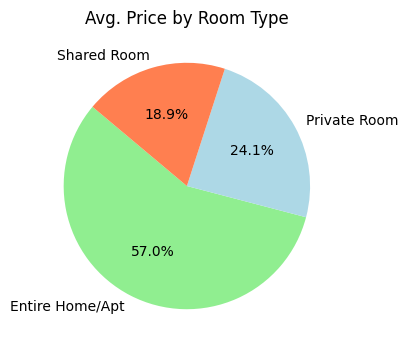

In [10]:
# How many avg. price by room type
avg_price_by_room_type = spark.sql("""
  SELECT
    CASE
      WHEN room_type = 'Entire home/apt'
      THEN 'Entire Home/Apt'
      WHEN room_type = 'Private room'
      THEN 'Private Room'
      ELSE 'Shared Room'
    END AS `Room Type`,
    ROUND(AVG(price),2) AS `Avg. Price`
  FROM AirbnbAnalytics
  WHERE room_type IN('Entire home/apt','Private room','Shared room')
  GROUP BY room_type
  ORDER BY `Avg. Price` DESC;
""")
# Display the result
avg_price_by_room_type.show()

# Convert Spark DataFrame to Pandas DataFrame
avg_price_by_room_type_pd = avg_price_by_room_type.toPandas()

# Plotting the pie chart
plt.figure(figsize=(5, 4))
plt.pie(
    avg_price_by_room_type_pd['Avg. Price'],
    labels=avg_price_by_room_type_pd['Room Type'],
    autopct='%1.1f%%',
    colors=['lightgreen', 'lightblue', 'coral'],  # Add more colors if necessary
    startangle=140
)
plt.title('Avg. Price by Room Type')
plt.show()


+---------------+-------------+
|      Room Type|Total Reviews|
+---------------+-------------+
|Entire Home/Apt|       578237|
|   Private Room|       535873|
|    Shared Room|        19148|
+---------------+-------------+



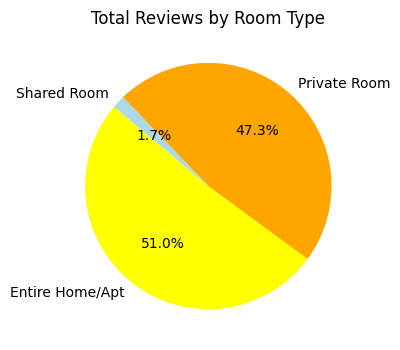

In [18]:
# How many total reviews by room type
total_review_by_room_type = spark.sql("""
  SELECT
    CASE
      WHEN room_type = 'Entire home/apt'
      THEN 'Entire Home/Apt'
      WHEN room_type = 'Private room'
      THEN 'Private Room'
      ELSE 'Shared Room'
    END AS `Room Type`,
    TRY_CAST(SUM(number_of_reviews) AS INT) AS `Total Reviews`
  FROM AirbnbAnalytics
  WHERE room_type IN('Entire home/apt','Private room','Shared room')
  GROUP BY room_type
  ORDER BY `Total Reviews` DESC;
""")
# Display the result
total_review_by_room_type.show()

# Convert Spark DataFrame to Pandas DataFrame
total_review_by_room_type_pd = total_review_by_room_type.toPandas()

# Plotting the pie chart
plt.figure(figsize=(5, 4))
plt.pie(
    total_review_by_room_type_pd['Total Reviews'],
    labels=total_review_by_room_type_pd['Room Type'],
    autopct='%1.1f%%',
    colors=['yellow', 'orange', 'lightblue'],  # Add more colors if necessary
    startangle=140
)
plt.title('Total Reviews by Room Type')
plt.show()

+-------------------+---------------+----------+
|Neighbourhood Group|      Room Type|Avg. Price|
+-------------------+---------------+----------+
|          Manhattan|Entire Home/Apt|    249.31|
|           Brooklyn|Entire Home/Apt|    178.38|
|      Staten Island|Entire Home/Apt|    173.75|
|             Queens|Entire Home/Apt|    147.12|
|              Bronx|Entire Home/Apt|    127.88|
|          Manhattan|   Private Room|    116.05|
|          Manhattan|    Shared Room|     89.07|
|           Brooklyn|   Private Room|     76.47|
|             Queens|   Private Room|     71.77|
|             Queens|    Shared Room|     69.02|
|              Bronx|   Private Room|     66.89|
|      Staten Island|   Private Room|     62.49|
|              Bronx|    Shared Room|      59.8|
|      Staten Island|    Shared Room|     57.44|
|           Brooklyn|    Shared Room|     50.53|
+-------------------+---------------+----------+



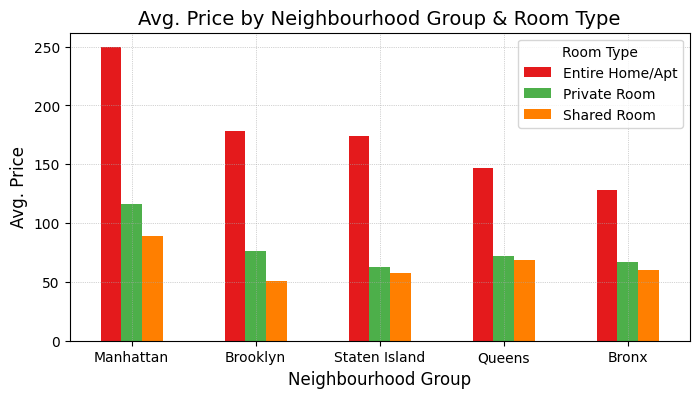

In [20]:
# How many avg. price by neighbourhood group & room type
avg_price_neighbourhood_room_type = spark.sql("""
  SELECT
    neighbourhood_group AS `Neighbourhood Group`,
    CASE
      WHEN room_type = 'Entire home/apt'
      THEN 'Entire Home/Apt'
      WHEN room_type = 'Private room'
      THEN 'Private Room'
      ELSE 'Shared Room'
    END AS `Room Type`,
    ROUND(AVG(price),2) AS `Avg. Price`
  FROM AirbnbAnalytics
  WHERE room_type IN('Entire home/apt','Private room','Shared room')
  GROUP BY neighbourhood_group, room_type
  ORDER BY `Avg. Price` DESC;
""")
# Display the result
avg_price_neighbourhood_room_type.show()

# Convert Spark DataFrame to Pandas DataFrame
avg_price_neighbourhood_room_type_pd = avg_price_neighbourhood_room_type.toPandas()

# Pivot the DataFrame to reorganize data by neighbourhood group and room type
avg_price_neighbourhood_room_type_pivot = avg_price_neighbourhood_room_type_pd.pivot_table(
    index='Neighbourhood Group',
    columns='Room Type',
    values='Avg. Price',
    aggfunc='mean'
)

# Add a column for avg. price and sort by it in descending order
avg_price_neighbourhood_room_type_pivot['Avg. Price'] = avg_price_neighbourhood_room_type_pivot.mean(axis=1)
avg_price_neighbourhood_room_type_pivot = avg_price_neighbourhood_room_type_pivot.sort_values('Avg. Price', ascending=False)

# Plot the data
color_palette = plt.cm.Set1([i / len(avg_price_neighbourhood_room_type_pivot.columns)
                             for i in range(len(avg_price_neighbourhood_room_type_pivot.columns))])

avg_price_neighbourhood_room_type_pivot.drop('Avg. Price', axis=1).plot(
    kind='bar',
    stacked=False,
    color=color_palette,
    figsize=(8, 4)
)

# Add plot details
plt.title('Avg. Price by Neighbourhood Group & Room Type', fontsize=14)
plt.ylabel('Avg. Price', fontsize=12)
plt.xlabel('Neighbourhood Group', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Room Type')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+-------------------+---------------+-------------+
|Neighbourhood Group|      Room Type|Total Reviews|
+-------------------+---------------+-------------+
|           Brooklyn|Entire Home/Apt|       266634|
|          Manhattan|Entire Home/Apt|       234544|
|           Brooklyn|   Private Room|       213287|
|          Manhattan|   Private Room|       207717|
|             Queens|   Private Room|        93236|
|             Queens|Entire Home/Apt|        59770|
|              Bronx|   Private Room|        16111|
|              Bronx|Entire Home/Apt|        11432|
|          Manhattan|    Shared Room|        10164|
|      Staten Island|Entire Home/Apt|         5857|
|           Brooklyn|    Shared Room|         5793|
|      Staten Island|   Private Room|         5522|
|             Queens|    Shared Room|         2745|
|              Bronx|    Shared Room|          432|
|      Staten Island|    Shared Room|           14|
+-------------------+---------------+-------------+



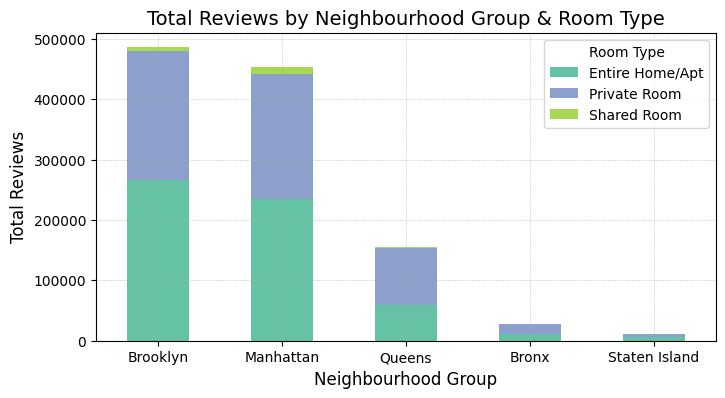

In [22]:
# How many total reviews by neighbourhood group & room type
total_reviews_neighbourhood_room_type = spark.sql("""
  SELECT
    neighbourhood_group AS `Neighbourhood Group`,
    CASE
      WHEN room_type = 'Entire home/apt'
      THEN 'Entire Home/Apt'
      WHEN room_type = 'Private room'
      THEN 'Private Room'
      ELSE 'Shared Room'
    END AS `Room Type`,
    TRY_CAST(SUM(number_of_reviews) AS INT) AS `Total Reviews`
  FROM AirbnbAnalytics
  WHERE room_type IN('Entire home/apt','Private room','Shared room')
  GROUP BY neighbourhood_group, room_type
  ORDER BY `Total Reviews` DESC;
""")
# Display the result
total_reviews_neighbourhood_room_type.show()

# Convert Spark DataFrame to Pandas DataFrame
total_reviews_neighbourhood_room_type_pd = total_reviews_neighbourhood_room_type.toPandas()

# Pivot the DataFrame to reorganize data by neighbourhood group and room type
total_reviews_neighbourhood_room_type_pivot = total_reviews_neighbourhood_room_type_pd.pivot_table(
    index='Neighbourhood Group',
    columns='Room Type',
    values='Total Reviews',
    aggfunc='sum'
)

# Add a column for total reviews and sort by it in descending order
total_reviews_neighbourhood_room_type_pivot['Total Reviews'] = total_reviews_neighbourhood_room_type_pivot.sum(axis=1)
total_reviews_neighbourhood_room_type_pivot = total_reviews_neighbourhood_room_type_pivot.sort_values('Total Reviews', ascending=False)

# Plot the data
color_palette = plt.cm.Set2([i / len(total_reviews_neighbourhood_room_type_pivot.columns)
                             for i in range(len(total_reviews_neighbourhood_room_type_pivot.columns))])

total_reviews_neighbourhood_room_type_pivot.drop('Total Reviews', axis=1).plot(
    kind='bar',
    stacked=True,
    color=color_palette,
    figsize=(8, 4)
)

# Add plot details
plt.title('Total Reviews by Neighbourhood Group & Room Type', fontsize=14)
plt.ylabel('Total Reviews', fontsize=12)
plt.xlabel('Neighbourhood Group', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Room Type')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+----------------+---------------+-------------+
|Last Review Year|      Room Type|Total Reviews|
+----------------+---------------+-------------+
|            2011|   Private Room|            1|
|            2011|   Private Room|           14|
|            2011|   Private Room|            2|
|            2011|   Private Room|            9|
|            2011|   Private Room|            1|
|            2011|Entire Home/Apt|           25|
|            2011|Entire Home/Apt|            9|
|            2012|Entire Home/Apt|            1|
|            2012|Entire Home/Apt|            1|
|            2012|   Private Room|            2|
|            2012|   Private Room|            7|
|            2012|   Private Room|            1|
|            2012|Entire Home/Apt|            2|
|            2012|Entire Home/Apt|            1|
|            2012|Entire Home/Apt|           31|
|            2012|Entire Home/Apt|            1|
|            2012|Entire Home/Apt|           30|
|            2012|En

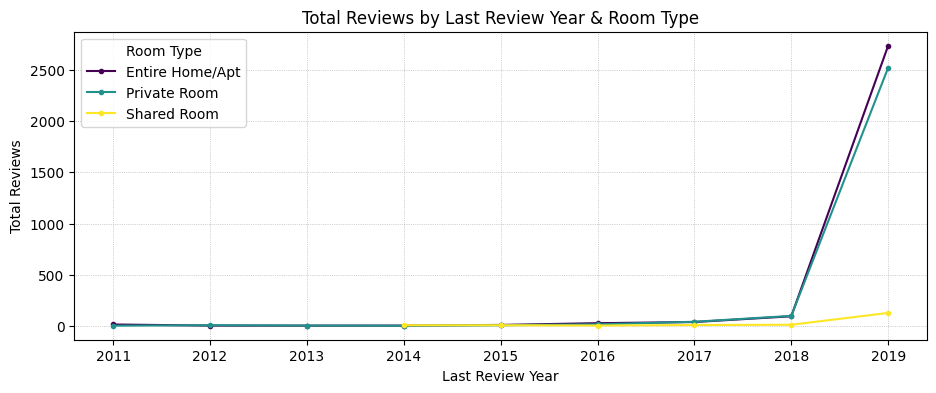

In [28]:
# How many total reviews by last review year & room type
total_reviews_last_review_year_room_type = spark.sql("""
  SELECT
    YEAR(last_review) AS `Last Review Year`,
    CASE
      WHEN room_type = 'Entire home/apt'
      THEN 'Entire Home/Apt'
      WHEN room_type = 'Private room'
      THEN 'Private Room'
      ELSE 'Shared Room'
    END AS `Room Type`,
    TRY_CAST(SUM(number_of_reviews) AS INT) AS `Total Reviews`
  FROM AirbnbAnalytics
  WHERE room_type IN('Entire home/apt','Private room','Shared room')
  AND YEAR(last_review) <> 1900
  GROUP BY last_review, room_type
  ORDER BY last_review;
""")
# Display the result
total_reviews_last_review_year_room_type.show()

# Convert Spark DataFrame to Pandas DataFrame
total_reviews_last_review_year_room_type_pd = total_reviews_last_review_year_room_type.toPandas()
# Visualize Total Sales by Order Year & Product Category
total_reviews_last_review_year_room_type_pd.groupby(['Last Review Year', 'Room Type'])['Total Reviews'].mean().unstack().plot(marker = '.',
                                                                                                                              cmap = 'viridis',
                                                                                                                              figsize = (11,4))
plt.title('Total Reviews by Last Review Year & Room Type', loc = 'center')
plt.xlabel('Last Review Year')
plt.ylabel('Total Reviews')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 0.5)
plt.show()